In [ ]:
#Import Dependencies
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [ ]:
#Variables to define
Ticker = "PLTR"
Forecast_Horizon = 5  #Predicting 5-day returns
n_splits = 5

In [ ]:
#Part 1: Preprocessing data to fit model

#Import data
def get_stock_data(ticker, period='1y'):
  df = yf.Ticker(ticker).history(period=period)
  df = df.drop(columns=["Dividends", "Stock Splits"], errors='ignore')
  return df

#Create data features
def create_features(df):
  df = df.copy()
  df['Lag_1'] = df['Close'].shift(1)
  df['MA_5'] = df['Close'].rolling(5).mean()
  df['MA_10'] = df['Close'].rolling(10).mean()
  df['MA_20'] = df['Close'].rolling(20).mean()
  df['Volatility_5'] = df['Close'].rolling(5).std()
  df['Momentum_10'] = (df['Close'] - df['Close'].shift(10))

  #Predicting future returns with given interval
  df['Target'] = (df['Close'].shift(-Forecast_Horizon) - df['Close']) / df['Close']

  df.dropna(inplace=True)
  return df

[Fold 1] RMSE: 0.1305, MAE: 0.0818, R²: -0.2200
[Fold 2] RMSE: 0.1866, MAE: 0.1337, R²: -3.6647
[Fold 3] RMSE: 0.1920, MAE: 0.1393, R²: -0.4295
[Fold 4] RMSE: 0.1328, MAE: 0.1115, R²: -0.4121
[Fold 5] RMSE: 0.1650, MAE: 0.1447, R²: -5.5136

--- Final Evaluation over All Folds ---
Avg RMSE: 0.1634
Avg MAE: 0.1222
Avg R²: -1.0228

--- Technical Indicators ---
MA_5: 140.2080
Volatility_5: 5.5327
RSI (n=14): 48.2554

--- Custom Input Prediction (Using Market values)---
MA_5: 140.2080
MA_10:134.97
MA_20:135.0
Volatility_5: 5.5327
Momentum_10: 0.3600
Predicted 5-day return: -0.1284
Estimated price in 5 days: $113.96


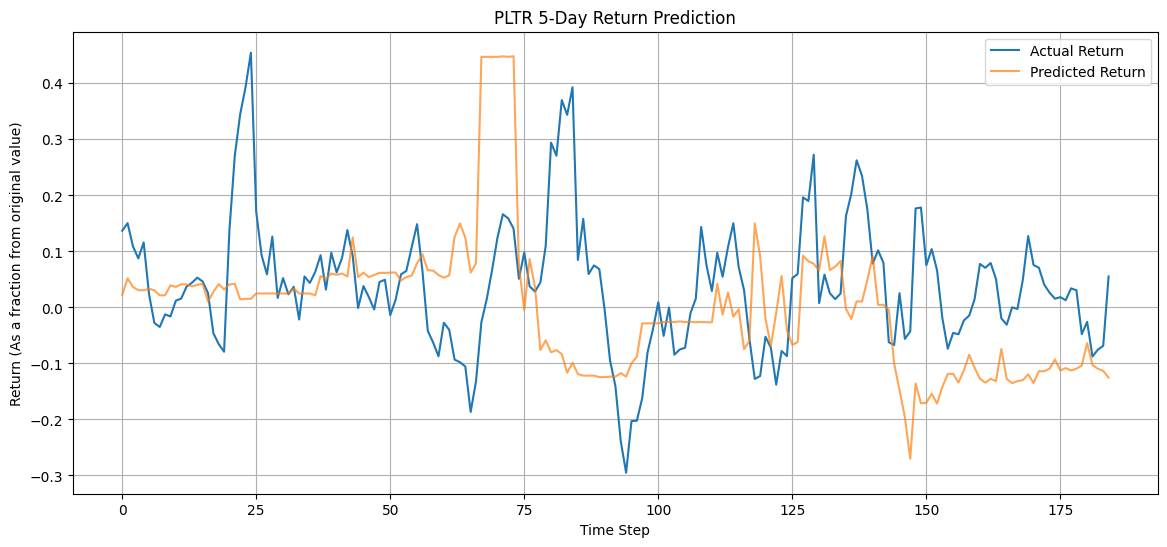

In [ ]:
#Part 2: Evaluating model
def evaluate_model(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  return rmse, mae, r2

#Implementing Model
def main_model():
  df = get_stock_data(Ticker)
  df = create_features(df)

  feature_cols = ['Lag_1', 'MA_5', 'MA_10', 'MA_20', 'Volatility_5', 'Momentum_10']
  X = df[feature_cols]
  y = df['Target']

  #Standardize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  #Split data into training and testing sets
  tscv = TimeSeriesSplit(n_splits=n_splits)
  all_preds, all_actuals = [], []

  for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Training Model: XGBoost
    model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    rmse, mae, r2 = evaluate_model(y_test, y_pred)
    print(f"[Fold {fold+1}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

  # Final evaluation
  final_rmse, final_mae, final_r2 = evaluate_model(all_actuals, all_preds)
  df['Volatility_5'] = df['Close'].rolling(window=5).std()
  Volatility_5 = df['Volatility_5'].iloc[-1]
  rsi = RSIIndicator(df['Close'], window=14)
  df['RSI'] = rsi.rsi()

  print("\n--- Final Evaluation over All Folds ---")
  print(f"Avg RMSE: {final_rmse:.4f}")
  print(f"Avg MAE: {final_mae:.4f}")
  print(f"Avg R²: {final_r2:.4f}")

  print("\n--- Technical Indicators ---")
  print(f"MA_5: {df['MA_5'].iloc[-1]:.4f}")
  print(f"Volatility_5: {Volatility_5:.4f}")
  print(f"RSI (n=14): {rsi.rsi().iloc[-1]:.4f}")

  """
  Using Custom Inputs for testing
  change inputs based on what the market is like right now
  """

  Lag_1 = 135.00
  MA_5 = df['MA_5'].iloc[-1]
  MA_10 = 134.97
  MA_20 = 135.00
  Momentum_10 = 0.36

  custom_input = {
    'Lag_1': Lag_1,
    'MA_5': MA_5,
    'MA_10': MA_10,
    'MA_20': MA_20,
    'Volatility_5': Volatility_5,
    'Momentum_10': Momentum_10
  }

  custom_df = pd.DataFrame([custom_input])
  custom_scaled = scaler.transform(custom_df)
  predicted_return = model.predict(custom_scaled)[0]
  predicted_price = df['Close'].iloc[-1] * (1 + predicted_return)

  print("\n--- Custom Input Prediction (Using Market values)---")
  print(f'MA_5: {MA_5:.4f}')
  print('MA_10:' + str(MA_10))
  print('MA_20:' + str(MA_20))
  print(f'Volatility_5: {Volatility_5:.4f}')
  print(f'Momentum_10: {Momentum_10:.4f}')
  print(f"Predicted 5-day return: {predicted_return:.4f}")
  print(f"Estimated price in 5 days: ${predicted_price:.2f}")

  # Visualization
  plt.figure(figsize=(14, 6))
  plt.plot(np.array(all_actuals), label="Actual Return")
  plt.plot(np.array(all_preds), label="Predicted Return", alpha=0.7)
  plt.title(f"{Ticker} 5-Day Return Prediction")
  plt.xlabel("Time Step")
  plt.ylabel("Return (As a fraction from original value)")
  plt.legend()
  plt.grid(True)
  plt.show()

main_model()